In [14]:
import os
import pandas as pd
import tensorflow as tf

os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Implementation

In [26]:
import sys
import keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print (f"Python Platform: {platform.platform ()}")
print (f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print ()

print (f"Python {sys.version}")
print (f"Pandas {pd.__version__}")
print (f"Scikit-Learn {sk.__version__}")
print (f"SciPy {sp.__version__}")
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")


Python Platform: macOS-14.5-arm64-arm-64bit
Tensor Flow Version: 2.16.2
Keras Version: 3.4.1

Python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.5.1
SciPy 1.10.1
GPU is available


In [27]:
df = pd.read_csv('../data/filtered_structured_data.csv')
print(len(df))
df.head()

45257


,patientid,sex,age,ANA,EXA,DIA_text,DIA_code,OP_text,OP_code
0,61.0,male,32.0,Beschwerden re. Achillessehne. NMR unauffällig...,Re. Achillessehne: Verdickung im Bereich der A...,Retropatellare Chondromalazie li; Insertionste...,M22.4 G,NaN,NaN
1,67.0,male,41.0,Seit mehreren Monaten Beschwerden re. Achilles...,Re. Achillessehne: Deutliche Auftreibung der A...,V.a.laterale Chondromalazie bei st.n. Außenmen...,M23.3- V,NaN,NaN
2,72.0,male,19.0,. .Gestern beim Training stechende Schmerzen l...,Klinischer Befund des Oberschenkels li.deutl.V...,Z.n.arthroskopischer Chirurgie des Kniegelenkes.,M23.3- Z,NaN,NaN
3,72.0,male,23.0,beide Knie Schmerzen bei Treppe steigen oder L...,bd. Knie: frei Bewegl.; Patella o.B.; keine MZ...,Z.n.IM-Teilresektion re.,S83.2 Z,NaN,NaN
4,84.0,male,57.0,(08.19 Uhr); bewegungsabhängig.Schmerzen wiede...,Klinischer Befund des Kniegelenks li.: Drucksc...,Beginnende Gonarthrose bds. li. mehr als re.,M17.9,NaN,NaN


45257


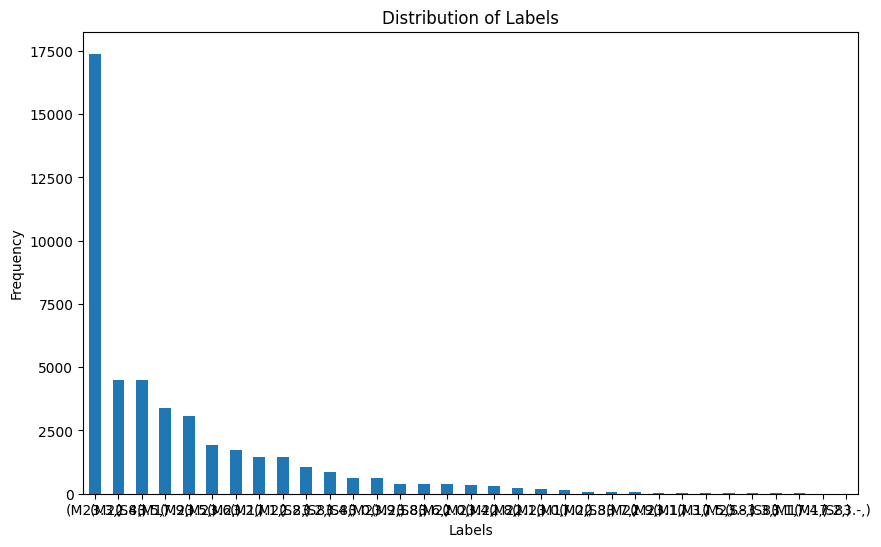

In [28]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
cols = ['ANA', 'EXA', 'age', 'sex']
df['data'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df['data'].head()
texts = df['data']
labels = df['DIA_code'].str[:5].to_frame()
label_counts = labels.value_counts()
encoder = OneHotEncoder()
labels = encoder.fit_transform(labels).toarray()
num_classes = len(encoder.categories_[0])
print(len(df))
# Count the occurrences of each label

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [11]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
print(tf.keras.utils.plot_model(model))
model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.
None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 400, 300)       │    16,243,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 400, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,598,989 (63.32 MB)

 Trainable params: 16,598,989 (63.32 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 90s 79ms/step - accuracy: 0.3738 - loss: 2.4070 - val_accuracy: 0.3920 - val_loss: 2.2915
Epoch 2/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.3838 - loss: 2.3074 - val_accuracy: 0.3920 - val_loss: 2.2935
Epoch 3/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 91s 81ms/step - accuracy: 0.3877 - loss: 2.2984 - val_accuracy: 0.3920 - val_loss: 2.2808
Epoch 4/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.3878 - loss: 2.2938 - val_accuracy: 0.3920 - val_loss: 2.2968
Epoch 5/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.3862 - loss: 2.2963 - val_accuracy: 0.3920 - val_loss: 2.2931
Epoch 6/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 109s 96ms/step - accuracy: 0.3810 - loss: 2.3011 - val_accuracy: 0.3920 - val_loss: 2.2807
Epoch 7/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 121s 107ms/step - accuracy: 0.3791 - loss: 2.3069 - val_accuracy: 0.3920 - val_loss: 2.2941
Epoch 8/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.379

# Embeddings

## Word2Vec

In [8]:
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Load spaCy model
nlp = spacy.load('de_core_news_sm')

def preprocess_text(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]', '', text)
    doc = nlp(text)
    stop_words = spacy.lang.de.stop_words.STOP_WORDS
    words = [token.text for token in doc if token.text.lower() not in stop_words and token.is_alpha]
    return words

def get_word2vec_embeddings(text, model, vector_size=300):
    tokens = preprocess_text(text)
    embeddings = np.zeros((len(tokens), vector_size))
    for i, token in enumerate(tokens):
        if token in model.wv:
            embeddings[i] = model.wv[token]
        else:
            embeddings[i] = np.zeros(vector_size)
    return embeddings

# Load pre-trained Word2Vec embeddings
w2v = Word2Vec.load("../data/word2vec.model")

# Convert texts to embeddings
word2vec_embeddings = [get_word2vec_embeddings(text, w2v) for text in texts]
padded_embeddings = pad_sequences(word2vec_embeddings, padding='post', dtype='float32')

# Determine the max length of the sequences
max_length = padded_embeddings.shape[1]

# Define model parameters
embedding_dim = 300  # Dimension of the Word2Vec embeddings
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length, embedding_dim), dtype='float32', name='text_input')

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(input_text)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_word2vec = Model(inputs=input_text, outputs=output)

# Compile the model
model_word2vec.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_word2vec.summary()

2024-07-17 20:36:45.826642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-17 20:36:45.826699: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-17 20:36:45.826712: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-17 20:36:45.826745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-17 20:36:45.826763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 208, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 208, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 208, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,489 (1.36 MB)

 Trainable params: 355,489 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
model_word2vec.fit(padded_embeddings, labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


2024-07-17 20:36:57.335163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - accuracy: 0.3747 - loss: 2.3998 - val_accuracy: 0.3920 - val_loss: 2.3329
Epoch 2/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.3888 - loss: 2.2967 - val_accuracy: 0.3920 - val_loss: 2.3102
Epoch 3/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.3771 - loss: 2.3114 - val_accuracy: 0.3920 - val_loss: 2.3022
Epoch 4/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.3825 - loss: 2.2978 - val_accuracy: 0.3920 - val_loss: 2.2963
Epoch 5/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.3816 - loss: 2.3063 - val_accuracy: 0.3920 - val_loss: 2.2964
Epoch 6/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.3853 - loss: 2.2882 - val_accuracy: 0.3920 - val_loss: 2.3036
Epoch 7/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.3838 - loss: 2.2874 - val_accuracy: 0.3920 - val_loss: 2.2996
Epoch 8/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.3790 - loss: 2.30

## Bert

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel

# Function to generate word embeddings for a given text
def generate_bert_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(inputs)
    embeddings = outputs.last_hidden_state
    return embeddings

model_name = "GerMedBERT/medbert-512"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

bert_embeddings = [generate_bert_embeddings(text, tokenizer, model).numpy().squeeze(0) for text in texts]
padded_embeddings = pad_sequences(bert_embeddings, padding='post', dtype='float32')


# Define model parameters
lstm_units = 128  # Number of LSTM units
embedding_dim = padded_embeddings.shape[-1]

# Define the input layers
input_text = Input(shape=(padded_embeddings.shape[1], embedding_dim), dtype='float32', name='text_input')

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(bert_embeddings)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_bert = Model(inputs=input_text, outputs=output)

# Compile the model
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-

KeyboardInterrupt: 

In [ ]:
model_bert.fit(padded_embeddings, labels, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
import pickle
with open('bert_embeddings.pkl', 'wb') as file: 
    pickle.dump(padded_embeddings, file) 

## Batchnormalization

### On input

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
vocab_size = 10000  # Size of the vocabulary
max_length = 400  # Length of input sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
print(tf.keras.utils.plot_model(model))
model.summary()

# Regularization

## No regularization

In [ ]:
from tensorflow.keras.regularizers import l1

# Tokenize the texts
vocab_size = 10000  # Size of the vocabulary
max_length = 400  # Length of input sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = LSTM(lstm_units)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
print(tf.keras.utils.plot_model(model))
model.summary()

## L1 Regularization

In [ ]:
from tensorflow.keras.regularizers import l1

# Tokenize the texts
vocab_size = 10000  # Size of the vocabulary
max_length = 400  # Length of input sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, kernel_regularizer=l1(0.01), return_sequences=True)(embedding)
x = LSTM(lstm_units, kernel_regularizer=l1(0.01))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
print(tf.keras.utils.plot_model(model))
model.summary()

## L2 Regularization

In [ ]:
from tensorflow.keras.regularizers import l2

# Tokenize the texts
vocab_size = 10000  # Size of the vocabulary
max_length = 400  # Length of input sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, kernel_regularizer=l2(0.01), return_sequences=True)(embedding)
x = LSTM(lstm_units, kernel_regularizer=l2(0.01))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
print(tf.keras.utils.plot_model(model))
model.summary()

## L1/L2 Regularization

In [ ]:
from tensorflow.keras.regularizers import l1_l2

# Tokenize the texts
vocab_size = 10000  # Size of the vocabulary
max_length = 400  # Length of input sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, kernel_regularizer=l1_l2(l1=0.01, l2=0.01), return_sequences=True)(embedding)
x = LSTM(lstm_units, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
print(tf.keras.utils.plot_model(model))
model.summary()

## Input Dropout Regularization

## Reccurent Dropout Regularization

In [ ]:
x = LSTM(lstm_units, recurrent_dropout=0.2, return_sequences=False)(x)